In [3]:
def add_pauli_rotation_gate(
    qc: "quimb.tensor.circuit.Circuit",
    pauli_string: str,
    theta: float,
    decompose_rzz: bool = True
):
    """
    Appends a Pauli rotation gate to a Quimb Circuit.
    Convention for Pauli string ordering is opposite to the Qiskit convention.
    For example, in string "XYZ" Pauli "X" acts on the first qubit.

    Parameters
    ----------
    qc : "quimb.tensor.circuit.Circuit"
        Quimb Circuit to which the Pauli rotation gate is appended.
    pauli_string : str
        Pauli string defining the rotation.
    theta : float
        Rotation angle.
    decompose_rzz : bool
        If decompose_rzz==True, all rzz gates are decompsed into cx-rz-cx.
        Otherwise, the final circuit contains rzz gates.

    Returns
    -------
    qc: Parameterized "quimb.tensor.circuit.Circuit"
    """

    if qc.N != len(pauli_string):
        raise ValueError("Circuit and Pauli string are of different size")
    if all([pauli=='I' or pauli=='X' or pauli=='Y' or pauli=='Z'
            for pauli in pauli_string])==False:
        raise ValueError("Pauli string does not have a correct format")

    nontriv_pauli_list = [(i,pauli)
                        for i,pauli in enumerate(pauli_string) if pauli!='I']
    
    if len(nontriv_pauli_list)==1:
        if nontriv_pauli_list[0][1]=='X':
            qc.apply_gate('RX',theta,nontriv_pauli_list[0][0],parametrize=True)
        if nontriv_pauli_list[0][1]=='Y':
            qc.apply_gate('RY',theta,nontriv_pauli_list[0][0],parametrize=True)        
        if nontriv_pauli_list[0][1]=='Z':
            qc.apply_gate('RZ',theta,nontriv_pauli_list[0][0],parametrize=True)    
    elif len(nontriv_pauli_list)==2 and nontriv_pauli_list[0][1]+nontriv_pauli_list[1][1] == 'XX':
            qc.apply_gate('RXX',theta,nontriv_pauli_list[0][0],nontriv_pauli_list[1][0],parametrize=True)
    elif len(nontriv_pauli_list)==2 and nontriv_pauli_list[0][1]+nontriv_pauli_list[1][1] == 'YY':
            qc.apply_gate('RYY',theta,nontriv_pauli_list[0][0],nontriv_pauli_list[1][0],parametrize=True)
    else:
        for (i,pauli) in nontriv_pauli_list:
            if pauli=='X':
                qc.apply_gate('H',i)
            if pauli=='Y':
                qc.apply_gate('SDG',i)
                qc.apply_gate('H',i)
        for list_ind in range(len(nontriv_pauli_list)-2):
            qc.apply_gate('CX',nontriv_pauli_list[list_ind][0],nontriv_pauli_list[list_ind+1][0])
        if decompose_rzz==True:
            qc.apply_gate(
                'CX',
                nontriv_pauli_list[len(nontriv_pauli_list)-2][0],
                nontriv_pauli_list[len(nontriv_pauli_list)-1][0]
            )
            qc.apply_gate('RZ',theta,nontriv_pauli_list[len(nontriv_pauli_list)-1][0],parametrize=True)
            qc.apply_gate(
                'CX',
                nontriv_pauli_list[len(nontriv_pauli_list)-2][0],
                nontriv_pauli_list[len(nontriv_pauli_list)-1][0]
            )
        if decompose_rzz==False:
            qc.apply_gate(
                'RZZ',
                theta,
                nontriv_pauli_list[len(nontriv_pauli_list)-2][0],
                nontriv_pauli_list[len(nontriv_pauli_list)-1][0],
                parametrize=True
            )
        for list_ind in reversed(range(len(nontriv_pauli_list)-2)):
            qc.apply_gate('CX',nontriv_pauli_list[list_ind][0],nontriv_pauli_list[list_ind+1][0])
        for (i,pauli) in nontriv_pauli_list:
            if pauli=='X':
                qc.apply_gate('H',i)
            if pauli=='Y':
                qc.apply_gate('H',i)
                qc.apply_gate('S',i)
    return qc

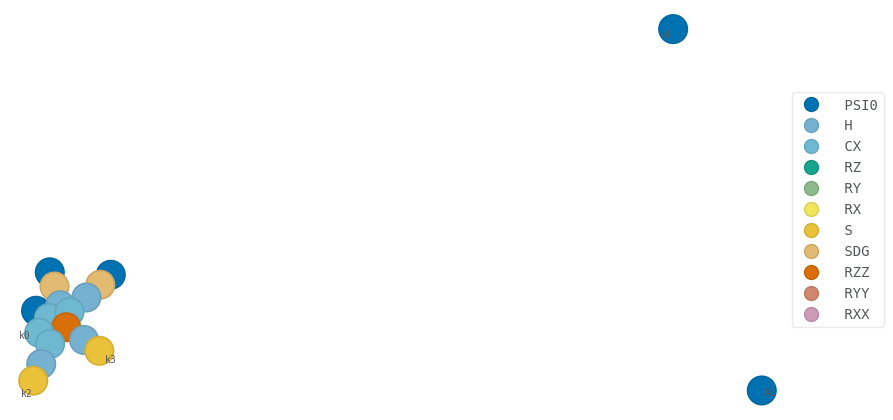

In [327]:
circ = qtn.Circuit(N=5)
circ = add_pauli_rotation_gate(circ,"ZIYYI",0.1,decompose_rzz=False)
circ.psi.draw(color=['PSI0', 'H', 'CX', 'RZ', 'RY', 'RX', 'S', 'SDG','RZZ','RYY','RXX'],figsize=(10,10))

In [328]:
circ.gates

(<Gate(label=SDG, params=[], qubits=(2,))>,
 <Gate(label=H, params=[], qubits=(2,))>,
 <Gate(label=SDG, params=[], qubits=(3,))>,
 <Gate(label=H, params=[], qubits=(3,))>,
 <Gate(label=CX, params=[], qubits=(0, 2))>,
 <Gate(label=RZZ, params=[0.1], qubits=(2, 3), parametrize=True))>,
 <Gate(label=CX, params=[], qubits=(0, 2))>,
 <Gate(label=H, params=[], qubits=(2,))>,
 <Gate(label=S, params=[], qubits=(2,))>,
 <Gate(label=H, params=[], qubits=(3,))>,
 <Gate(label=S, params=[], qubits=(3,))>)

In [329]:
circ.set_params({[key for key in circ.get_params().keys()][0]: [0.5]})

In [330]:
circ.gates

(<Gate(label=SDG, params=[], qubits=(2,))>,
 <Gate(label=H, params=[], qubits=(2,))>,
 <Gate(label=SDG, params=[], qubits=(3,))>,
 <Gate(label=H, params=[], qubits=(3,))>,
 <Gate(label=CX, params=[], qubits=(0, 2))>,
 <Gate(label=RZZ, params=[0.5], qubits=(2, 3), parametrize=True))>,
 <Gate(label=CX, params=[], qubits=(0, 2))>,
 <Gate(label=H, params=[], qubits=(2,))>,
 <Gate(label=S, params=[], qubits=(2,))>,
 <Gate(label=H, params=[], qubits=(3,))>,
 <Gate(label=S, params=[], qubits=(3,))>)

In [4]:
class model_H:
    def __init__(
        self,
        incar_file: str
    ):
        with open(incar_file) as fp:
            incar_content = fp.read()

        h_pos = incar_content.find("h")
        pool_pos = incar_content.find("pool")
        h_string = incar_content[h_pos+14:pool_pos-14]

        self.paulis = "".join([el for el in h_string if el=='I' or el=='X' or el=='Y' or el=='Z' or el == '\n']).split('\n')

        coefs_str = "".join([el for el in h_string if el.isdigit() or el=="-" or el=="." or el == "*"]).split('*')
        self.coefs = [float(el) for el in coefs_str[0:-1]]

In [328]:
import numpy as np
import pickle
import time
from tqdm import tqdm
from typing import (
    List,
    Optional,
    Tuple,
    Union
)

import quimb as qu
import quimb.tensor as qtn

import cotengra as ctg

class Quimb_avqite_contractions_estimates:
    def __init__(
        self,
        num_qubits: int,
        g: float,
        filename: str
    ):
        self._num_qubits = num_qubits
        self._g = g
        self._filename = filename

        self._H = model_H("incars/incar"+self._filename)
        
        #Reads out the ansatz file.
        (self._ansatz_adaptvqite,
         self._params_ansatz) = self.read_adaptvqite_ansatz("adaptvqite/adaptvqite/data/ansatz_inp.pkle")         
            
        #Reads out the incar file.
        with open("incars/incar"+self._filename) as fp:
            incar_content = fp.read()
        ref_st_r_pos = incar_content.find("ref_state")
        #Reads out the reference state from the incar file.
        self._ref_state = incar_content[
                            ref_st_r_pos+13:ref_st_r_pos+13+self._num_qubits
                            ]

        #Initializes a QuantumCircuit object.
        self._init_qc = qtn.Circuit(N=self._num_qubits)

        #If the reference state contains "1"s, adds corresponding bit-flips.
        if all([(el=='0') or (el=='1') for el in self._ref_state]):
            [self._init_qc.apply_gate('X',i) for i,el in enumerate(self._ref_state) if el=='1']
        else:
            raise ValueError(
                "Reference state is supposed to be a string of 0s and 1s"
            )
                    
        self.pauli_rot_gates_list = [add_pauli_rotation_gate(qc=qtn.Circuit(N=self._num_qubits),pauli_string=self._ansatz_adaptvqite[i],theta=self._params_ansatz[i],decompose_rzz=False).gates for i in range(len(self._ansatz_adaptvqite))]
        
        self.pauli_rot_dag_gates_list = [add_pauli_rotation_gate(qc=qtn.Circuit(N=self._num_qubits),pauli_string=self._ansatz_adaptvqite[i],theta=-self._params_ansatz[i],decompose_rzz=False).gates for i in range(len(self._ansatz_adaptvqite))]
    
        self.base_circuits = [self.circuit_2(mu) for mu in range(len(self._ansatz_adaptvqite)+1)]    
        
    
    def read_adaptvqite_ansatz(
        self,
        filename: str
    ):
        """
        Reads the ansatz from a file resulting from adaptvqite calculation.

        Parameters
        ----------
        filename : str
            Name of a file containing the results of adaptvqite calculation.
            Has to be given in .pkle format.

        Returns
        -------
        ansatz_adaptvqite : List[str]
            List of Pauli strings entering the ansatz.
        params_adaptvqite : List[float64]
            Parameters (angles) of the ansatz.
        """
        if filename[-5:] != '.pkle':
            raise ImportError("Ansatz file should be given in .pkle format")

        with open(filename, 'rb') as inp:
            data_inp = pickle.load(inp)
            ansatz_adaptvqite = data_inp[0]
            params_adaptvqite = data_inp[1]
            # params_adaptvqite = list(np.random.random(20))

        return ansatz_adaptvqite, params_adaptvqite
    
    
    def pauli_string_to_quimb_gates(
        self,
        pauli_string
    ):
        gates = ()
        for i,el in enumerate(pauli_string):
            if el=='X':
                gates = gates + (qtn.circuit.Gate(label='X', params=[], qubits=(i,)),)
            if el=='Y':
                gates = gates + (qtn.circuit.Gate(label='Y', params=[], qubits=(i,)),)
            if el=='Z':
                gates = gates + (qtn.circuit.Gate(label='Z', params=[], qubits=(i,)),)
        return gates

    
    def circuit_1(
        self,
        mu: int,
        nu: int,
        A_mu: Union["Instruction", "Operator"],
        A_nu: Union["Instruction", "Operator"]
    ):
        if mu >= nu:
            raise ValueError("Here mu<nu is required.")
        if mu > len(self._ansatz_adaptvqite) or nu > len(self._ansatz_adaptvqite):
            raise ValueError("mu, nu has to be smaller than the number of operators in the ansatz")
            
        qc = self.base_circuits[mu].copy()
        

        qc.apply_gates( self.pauli_string_to_quimb_gates(pauli_string=A_mu), contract=False )
        for i in range(mu,nu):
             qc.apply_gates(self.pauli_rot_gates_list[i], contract=False)
        qc.apply_gates( self.pauli_string_to_quimb_gates(pauli_string=A_nu), contract=False )
        for i in reversed(range(nu)):
            qc.apply_gates(self.pauli_rot_dag_gates_list[i], contract=False)

        return qc    


    def circuit_2(
        self,
        mu: int
    ):
        qc = self._init_qc.copy()
    
        for i in range(mu):
            qc.apply_gates(self.pauli_rot_gates_list[i], contract=False)
        
        return qc


    def quimb_ampl_contr_est(
        self,
        circuit,
        opt = 'hyper'
    ):
        t3 = time.time()
        reh = circuit.amplitude_rehearse('0'*self._num_qubits, optimize=opt)
        t4 = time.time()
        width, cost = reh['tree'].contraction_width(), reh['tree'].contraction_cost()
        t5 = time.time()
        contraction = reh['tn'].contract(all, optimize=reh['tree'], output_inds=())
        t6 = time.time()
        
        # print(t4-t3,t5-t4,t6-t5)
        return width, cost, contraction

    
    def quimb_local_exp_contr_est(
        self,
        circuit,
        operator,
        where,
        opt = 'hyper'
    ):
        reh = circuit.local_expectation_rehearse(operator, where, optimize=opt)

        width, cost = reh['tree'].contraction_width(), reh['tree'].contraction_cost()

        contraction = reh['tn'].contract(all, optimize=reh['tree'], output_inds=())
        
        return width, cost, contraction

    
    def h_exp_value(
        self,
        params,
        opt = None
    ):
        
        opt_reuse = ctg.ReusableHyperOptimizer(
            max_repeats=16,
            reconf_opts={},
            parallel=False,
            progbar=False,
        #     directory=True,  # if you want a persistent path cache
        )
        
        if opt==None:
            opt='greedy'
        
        qc = self.base_circuits[-1].copy()
        
        old_params_dict = qc.get_params()
        new_params_dict = dict()
        for i,key in enumerate(old_params_dict.keys()):
            new_params_dict[key]= np.array([params[i]])
        
        qc.set_params(new_params_dict)
        
        h_exp_vals = []


        
        for pauli_string in self._H.paulis:
            where = [i for i,p in enumerate(pauli_string) if p!= 'I']
            paulis = [p for i,p in enumerate(pauli_string) if p!= 'I']
            
            operator = qu.pauli(paulis[0])
            for i in range(1,len(where)):
                operator = operator & qu.pauli(paulis[i])                
        
            width, cost, contraction = self.quimb_local_exp_contr_est(circuit = qc, operator = operator, where = where, opt=opt)

            h_exp_vals.append(contraction)
            
        exp_value = sum([h_exp_vals[i]*self._H.coefs[i] for i in range(len(self._H.coefs))])

        return exp_value
        
    
    
    def avqite_contr_est(
        self,
        contr_type: int,
        mu: Optional[int] = None,
        nu: Optional[int] = None,
    ):        
        if contr_type == 1 and type(mu) != int and type(nu) != int:
            raise ValueError("For contraction type 1, both mu and nu have to be int")
        if contr_type == 2 and type(mu) != int and nu != None:
            raise ValueError("For contraction type 2, mu has to be int and nu has to be None")
        if contr_type == 3 and type(mu) != int and nu != None:
            raise ValueError("For contraction type 3, mu has to be int and nu has to be None")
        if contr_type == 4 and mu != None and nu != None:
            raise ValueError("For contraction type 4, mu has to be None and nu has to be None")
        if contr_type == 5 and mu != None and nu != None:
            raise ValueError("For contraction type 5, mu has to be None and nu has to be None")        

        if mu != None and nu != None:
            if mu > len(self._ansatz_adaptvqite) or nu > len(self._ansatz_adaptvqite):
                raise ValueError("mu, nu has to be smaller than the number of operators in the ansatz")

        if contr_type == 1:
            if mu<nu:
                t1=time.time()
                qc = self.circuit_1(mu, nu, A_mu = self._ansatz_adaptvqite[mu], A_nu = self._ansatz_adaptvqite[nu])
                t2=time.time()
                width, cost, contraction = self.quimb_ampl_contr_est(circuit = qc)
                t3=time.time()
                # print(t2-t1,t3-t2)
            if mu==nu:
                width, cost, contraction = (1,0,1) 
            contraction = np.real(contraction)/4
                
        if contr_type == 2:
            qc = self.base_circuits[mu]
            where = [i for i,p in enumerate(self._ansatz_adaptvqite[mu]) if p!= 'I']
            paulis = [p for i,p in enumerate(self._ansatz_adaptvqite[mu]) if p!= 'I']

            operator = qu.pauli(paulis[0])
            for i in range(1,len(where)):
                operator = operator & qu.pauli(paulis[i])
            
            width, cost, contraction = self.quimb_local_exp_contr_est(circuit = qc, operator = operator, where = where)
            contraction = np.real(1j*contraction/2)

        return width, cost, contraction

In [329]:
test_obj = Quimb_avqite_contractions_estimates(num_qubits = 16, g=0.5, filename = "N16g0.5")

In [330]:
%%time 
test_obj.h_exp_value(params = test_obj._params_ansatz)

CPU times: user 872 ms, sys: 40.5 ms, total: 912 ms
Wall time: 888 ms


(-16.96463510252487+0j)

In [ ]:
%%time
test_obj.h_exp_value(params = test_obj._params_ansatz)

In [324]:
%%time 
test_obj.h_exp_value(params = test_obj._params_ansatz)

F=1.96 C=3.57 S=3.00 P=5.46: 100%|██████████| 16/16 [00:00<00:00, 50.13it/s]

CPU times: user 2.71 s, sys: 8.36 ms, total: 2.72 s
Wall time: 2.7 s


(-16.96463510252487+0j)

In [312]:
V_mu = np.zeros(len(test_obj._ansatz_adaptvqite))

for mu in tqdm(range(len(test_obj._params_ansatz))):
    params1 = test_obj._params_ansatz.copy()
    params1[mu] = params1[mu]+np.pi/2
    params2 = test_obj._params_ansatz.copy()
    params2[mu] = params2[mu]-np.pi/2
    
    V_mu[mu] = -1/2*(test_obj.h_exp_value(params1) - test_obj.h_exp_value(params2) )

  0%|          | 0/53 [00:00<?, ?it/s]/tmp/ipykernel_1117057/2694974115.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  V_mu[mu] = -1/2*(test_obj.h_exp_value(params1) - test_obj.h_exp_value(params2) )
100%|██████████| 53/53 [01:34<00:00,  1.78s/it]


In [313]:
V_mu/2

array([-0.04876718, -0.04770977, -0.04950302, -0.04944607, -0.05005351,
       -0.05012101, -0.04952011, -0.04955434, -0.04874001, -0.05010579,
       -0.0495121 , -0.04968631, -0.05033749, -0.05038903, -0.04867863,
       -0.0491465 , -0.04909443, -0.04749004, -0.04772181, -0.04884054,
       -0.04960212, -0.04874522, -0.04955256, -0.04886982, -0.04795811,
       -0.04724211, -0.04836011, -0.04807815, -0.04970762, -0.04969232,
       -0.04926751, -0.04926966, -0.05000258, -0.04877366, -0.04953833,
       -0.04953982, -0.04951899, -0.0487486 , -0.04908059, -0.04944607,
       -0.04904989, -0.04914695, -0.04913538, -0.04867863, -0.04598353,
       -0.04583569, -0.04583132, -0.04538079, -0.04597752, -0.0454438 ,
       -0.04877366, -0.04636264, -0.04908059])

In [311]:
V_adaptvqite

array([-0.04876718, -0.04770977, -0.04950302, -0.04944607, -0.05005351,
       -0.05012101, -0.04952011, -0.04955434, -0.04874001, -0.05010579,
       -0.0495121 , -0.04968631, -0.05033749, -0.05038903, -0.04867863,
       -0.0491465 , -0.04909443, -0.04749004, -0.04772181, -0.04884054,
       -0.04960212, -0.04874522, -0.04955256, -0.04886982, -0.04795811,
       -0.04724211, -0.04836011, -0.04807815, -0.04970762, -0.04969232,
       -0.04926751, -0.04926966, -0.05000258, -0.04877366, -0.04953833,
       -0.04953982, -0.04951899, -0.0487486 , -0.04908059, -0.04944607,
       -0.04904989, -0.04914695, -0.04913538, -0.04867863, -0.04598353,
       -0.04583569, -0.04583132, -0.04538079, -0.04597752, -0.0454438 ,
       -0.04877366, -0.04636264, -0.04908059])

In [309]:
%%time
test_obj.avqite_contr_est(contr_type = 1, mu = 3, nu = 6)[-1]

CPU times: user 6.79 ms, sys: 43 μs, total: 6.84 ms
Wall time: 5.88 ms


0.0

In [238]:
%%time

M_munu = np.zeros((len(test_obj._ansatz_adaptvqite),len(test_obj._ansatz_adaptvqite)))

for nu in tqdm(range(len(test_obj._ansatz_adaptvqite))):
    for mu in range(nu+1):
        M_munu[mu,nu] = test_obj.avqite_contr_est(contr_type = 1, mu = mu, nu = nu)[-1] + test_obj.avqite_contr_est(contr_type = 2, mu = mu)[-1]*test_obj.avqite_contr_est(contr_type = 2, mu = nu)[-1]
        M_munu[nu,mu] = M_munu[mu,nu]

100%|██████████| 30/30 [00:22<00:00,  1.32it/s]

CPU times: user 22.7 s, sys: 10.9 ms, total: 22.7 s
Wall time: 22.7 s


In [310]:
with open("adaptvqite/adaptvqite/data/M_V.pkle", 'rb') as inp:
    data_inp = pickle.load(inp)
    M_adaptvqite = data_inp[0]
    V_adaptvqite = data_inp[1]

In [240]:
Mdiff = M_adaptvqite - M_munu
np.where((Mdiff>1e-14) == True)

(array([], dtype=int64), array([], dtype=int64))

In [98]:
%%time

M_munu1_width = np.zeros((len(test_obj._ansatz_adaptvqite),len(test_obj._ansatz_adaptvqite)))
M_munu1_cost = np.zeros((len(test_obj._ansatz_adaptvqite),len(test_obj._ansatz_adaptvqite)))

# M_munu1_width = np.zeros((30,30))
# M_munu1_cost = np.zeros((30,30))

for nu in tqdm(range(len(test_obj._ansatz_adaptvqite))):
# for nu in range(30):
    for mu in range(nu+1):
        M_munu1_width[mu,nu],M_munu1_cost[mu,nu] = (test_obj.avqite_contr_est(contr_type = 1, mu = mu, nu = nu)[0],test_obj.avqite_contr_est(contr_type = 1, mu = mu, nu = nu)[1])
        M_munu1_width[nu,mu] = M_munu1_width[mu,nu]
        M_munu1_cost[nu,mu] = M_munu1_cost[mu,nu]
M_munu1_width, M_munu1_cost

100%|██████████| 28/28 [00:22<00:00,  1.27it/s]

CPU times: user 22.1 s, sys: 9.77 ms, total: 22.1 s
Wall time: 22.1 s


(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1

In [34]:
M_munu2_width = np.zeros(len(test_obj._ansatz_adaptvqite))
M_munu2_cost = np.zeros(len(test_obj._ansatz_adaptvqite))

for mu in range(len(test_obj._ansatz_adaptvqite)):
    M_munu1_width[mu],M_munu1_cost[mu] = (test_obj.avqite_contr_est(contr_type = 3, mu = mu)[0],test_obj.avqite_contr_est(contr_type = 3, mu = mu)[1])
M_munu2_width, M_munu2_cost

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [9]:
test_obj.avqite_contr_est(contr_type = 2, mu = 1)

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 (-8.452898805160866e-17+0.07175917717210209j))

In [59]:
 test_obj.avqite_contr_est(contr_type = 3, mu = mu)

(1, 0, 0j)

In [60]:
test_obj.avqite_contr_est(contr_type = 3, mu = nu)

(1, 0, 1.9602028564652387e-17j)

In [31]:
M_munu = np.zeros((len(test_obj._ansatz_adaptvqite),len(test_obj._ansatz_adaptvqite)))

for nu in range(len(test_obj._ansatz_adaptvqite)):
    for mu in range(nu):
        M_munu[mu,nu] = 2*(test_obj.avqite_contr_est(contr_type = 1, mu = mu, nu = nu)[-1] + test_obj.avqite_contr_est(contr_type = 3, mu = mu)[-1]*test_obj.avqite_contr_est(contr_type = 3, mu = nu)[-1]) 


/tmp/ipykernel_1453968/2578387220.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  M_munu[mu,nu] = 2*(test_obj.avqite_contr_est(contr_type = 1, mu = mu, nu = nu)[-1] + test_obj.avqite_contr_est(contr_type = 3, mu = mu)[-1]*test_obj.avqite_contr_est(contr_type = 3, mu = nu)[-1])
/tmp/ipykernel_1453968/2578387220.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  M_munu[mu,nu] = 2*(test_obj.avqite_contr_est(contr_type = 1, mu = mu, nu = nu)[-1] + test_obj.avqite_contr_est(contr_type = 3, mu = mu)[-1]*test_obj.avqite_contr_est(contr_type = 3, mu = nu)[-1])
/tmp/ipykernel_1453968/2578387220.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  M_munu[mu,nu] = 2*(test_obj.avqite_contr_est(contr_type = 1, mu = mu, nu = nu)[-1] + test_obj.avqite_contr_est(contr_type = 3, mu = mu)[-1]*test_obj.avqite_contr_est(contr_type = 3, mu = nu)[-1])


In [34]:
M_munu/8

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00, -2.56917212e-18,  1.37851900e-36,
         1.21095263e-35,  5.76712094e-37,  6.88684513e-36,
        -1.24900693e-35,  2.37821940e-36,  2.47617228e-01,
         1.05357478e-33, -9.62340565e-35, -1.82725618e-34,
         6.30261397e-35,  2.32733389e-01,  3.82866656e-33,
        -1.52636409e-33, -9.05975011e-34, -9.12912568e-03,
         1.31080786e-32, -2.40741243e-35, -8.09093380e-34,
         2.47617228e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -9.63116549e-19,  9.06818877e-36,
         2.90686713e-22,  7.91364316e-35,  2.02295226e-34,
         6.27190270e-34,  2.40380805e-01, -1.70382986e-33,
         1.55756569e-33,  2.82429205e-34, -1.06597387e-34,
        -5.13446471e-34, -2.00

In [6]:
test_obj.avqite_contr_est(contr_type = 3, mu = 7)

(1, 0, (-1.504632769052528e-36+0j))

In [7]:
type(Pauli('IIIIIIIYIIII'))

qiskit.quantum_info.operators.symplectic.pauli.Pauli

In [80]:
circuit.append(Pauli(test_obj._ansatz_adaptvqite[1]), range(test_obj._num_qubits))

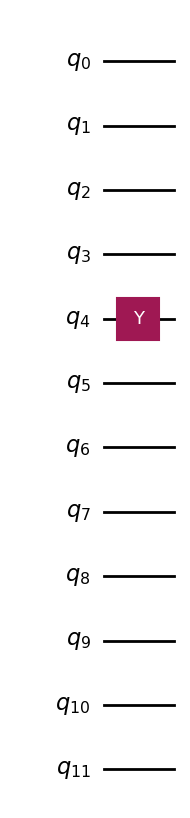

In [83]:
circuit.decompose().draw('mpl')

In [77]:
circuit = test_obj._init_circuit.copy()

In [40]:
test_obj = Quimb_avqite_contractions_estimates(num_qubits = 12, g=0.1, filename = "N12g0.1")
test_circ = test_obj.circuit_1(mu = 1,nu = 12,A_mu = Pauli(test_obj._ansatz_adaptvqite[1]),A_nu = Pauli(test_obj._ansatz_adaptvqite[12]))




In [51]:
test_circ = test_obj.circuit_1(mu = 1,nu = 12,A_mu = test_obj._H.paulis[0],A_nu = Pauli(test_obj._ansatz_adaptvqite[12]))

In [52]:
test_circ

In [50]:
test_obj._H.paulis[0]

Pauli('ZZIIIIIIIIII')

In [45]:
test_obj._H

SparsePauliOp(['ZZIIIIIIIIII', 'IZZIIIIIIIII', 'IIZZIIIIIIII', 'IIIZZIIIIIII', 'IIIIZZIIIIII', 'IIIIIZZIIIII', 'IIIIIIZZIIII', 'IIIIIIIZZIII', 'IIIIIIIIZZII', 'IIIIIIIIIZZI', 'IIIIIIIIIIZZ', 'XIIIIIIIIIII', 'IXIIIIIIIIII', 'IIXIIIIIIIII', 'IIIXIIIIIIII', 'IIIIXIIIIIII', 'IIIIIXIIIIII', 'IIIIIIXIIIII', 'IIIIIIIXIIII', 'IIIIIIIIXIII', 'IIIIIIIIIXII', 'IIIIIIIIIIXI', 'IIIIIIIIIIIX'],
              coeffs=[-1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j,
 -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j,  0.1+0.j,  0.1+0.j,  0.1+0.j,
  0.1+0.j,  0.1+0.j,  0.1+0.j,  0.1+0.j,  0.1+0.j,  0.1+0.j,  0.1+0.j,
  0.1+0.j,  0.1+0.j])

In [33]:
Pauli(test_obj._ansatz_adaptvqite[2]).to_instruction()

Instruction(name='pauli', num_qubits=12, num_clbits=0, params=['IIIIIIIIYIII'])

In [ ]:
circuit.append(Pauli(test_obj._ansatz_adaptvqite[2]).to_instruction(), range(test_obj._num_qubits))

In [23]:
circuit.append(Pauli(test_obj._ansatz_adaptvqite[2]).to_instruction(), range(test_obj._num_qubits))

In [18]:
Pauli(test_obj._ansatz_adaptvqite[2])

Pauli('IIIIIIIIYIII')

In [19]:
circuit.append(Pauli(test_obj._ansatz_adaptvqite[2]), range(self._num_qubits))

NameError: name 'circuit' is not defined

In [2]:
# the kwargs ReusableHyperOptimizer take are the same as HyperOptimizer
opt = ctg.ReusableHyperOptimizer(
    max_repeats=16,
    reconf_opts={},
    parallel=False,
    progbar=True,
#     directory=True,  # if you want a persistent path cache
)

In [15]:
test_obj._H

SparsePauliOp(['ZZIIIIIIIIII', 'IZZIIIIIIIII', 'IIZZIIIIIIII', 'IIIZZIIIIIII', 'IIIIZZIIIIII', 'IIIIIZZIIIII', 'IIIIIIZZIIII', 'IIIIIIIZZIII', 'IIIIIIIIZZII', 'IIIIIIIIIZZI', 'IIIIIIIIIIZZ', 'XIIIIIIIIIII', 'IXIIIIIIIIII', 'IIXIIIIIIIII', 'IIIXIIIIIIII', 'IIIIXIIIIIII', 'IIIIIXIIIIII', 'IIIIIIXIIIII', 'IIIIIIIXIIII', 'IIIIIIIIXIII', 'IIIIIIIIIXII', 'IIIIIIIIIIXI', 'IIIIIIIIIIIX'],
              coeffs=[-1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j,
 -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j,  0.1+0.j,  0.1+0.j,  0.1+0.j,
  0.1+0.j,  0.1+0.j,  0.1+0.j,  0.1+0.j,  0.1+0.j,  0.1+0.j,  0.1+0.j,
  0.1+0.j,  0.1+0.j])

In [13]:
test_obj = Quimb_avqite_contractions_estimates(num_qubits = 12, g=0.1, filename = "N12g0.1")

In [4]:
test_circ = test_obj.circuit_1(1,12)
test_obj.quimb_ampl_contr_est(test_circ)

(1, 0, (-5.840629185526186e-37-6.266269913450338e-35j))

In [29]:
contraction)

numpy.complex128

In [7]:
reh = test_circ_quimb.amplitude_rehearse('000000000000', optimize=opt)

(reh['tree'].contraction_width(), reh['tree'].contraction_cost())

(1, 0)

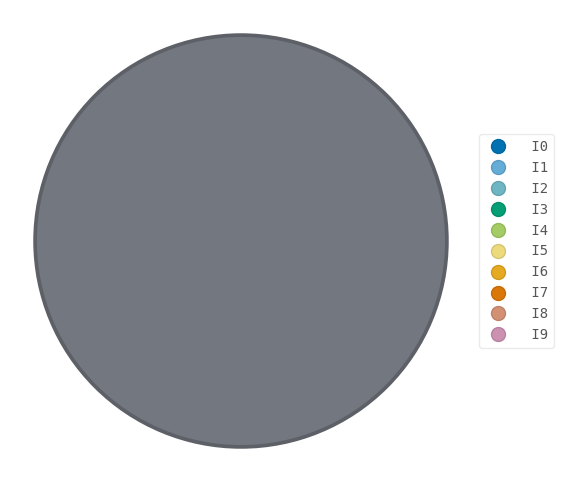

In [8]:
(
    test_circ_quimb.amplitude_rehearse('000000000000',simplify_sequence='ADCRS')['tn'].draw(color=[f'I{q}' for q in range(10)])
)

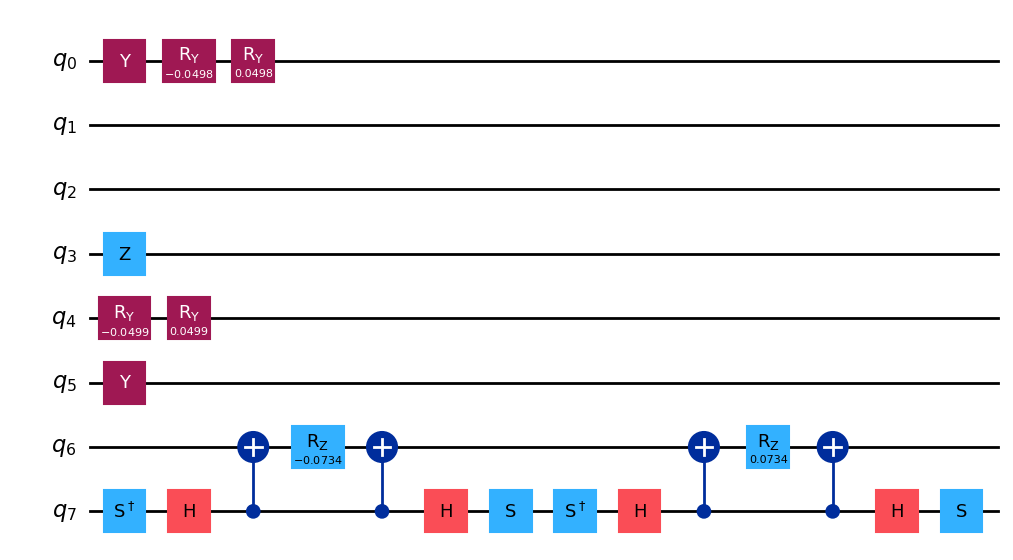

In [204]:
test_circ.decompose().draw('mpl')

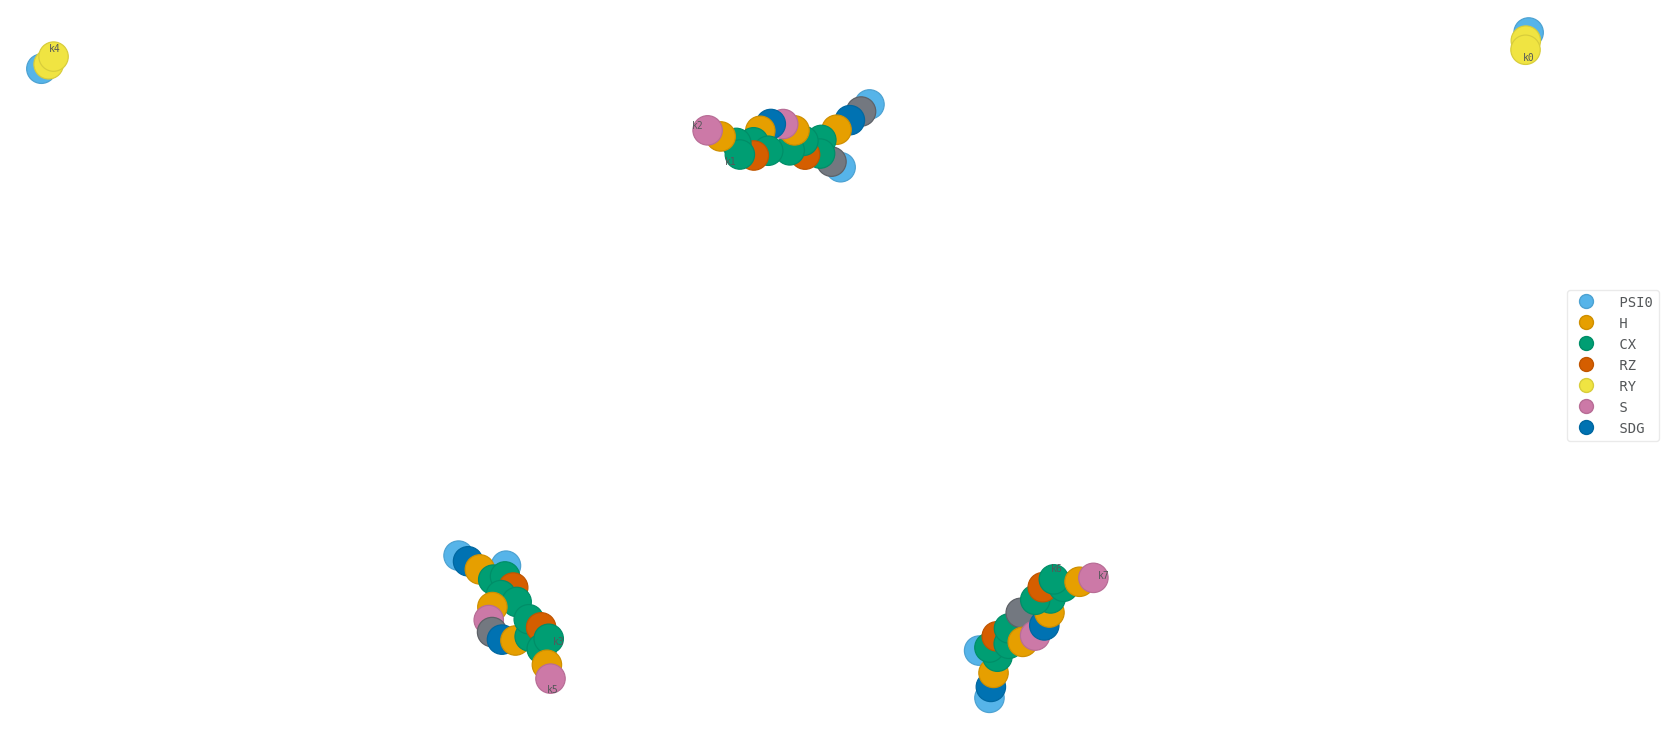

In [191]:
test_circ_quimb.psi.draw(color=['PSI0', 'H', 'CX', 'RZ', 'RY', 'S', 'SDG'],figsize=(20,20))

In [106]:
qiskit_varqite_obj_N8 = Noisy_varqite_qiskit_tfim(num_qubits = 8)

In [5]:
qiskit_varqite_obj_N12 = Noisy_varqite_qiskit_tfim(num_qubits = 12)

In [6]:
qiskit_varqite_obj_N8.filename = "N8g0.1"

ansatz0, init_params = qiskit_varqite_obj_N8.set_ansatz(
        ansatz_type= "adaptvqite",
        EfficientSU2_reps= None
    )

ansatz_N8g01 = ansatz0.assign_parameters(init_params)

In [107]:
qiskit_varqite_obj_N12.filename = "N12g0.1"

ansatz0, init_params = qiskit_varqite_obj_N12.set_ansatz(
        ansatz_type= "adaptvqite",
        EfficientSU2_reps= None
    )

ansatz_N12g01 = ansatz0.assign_parameters(init_params)

In [42]:
qiskit_varqite_obj_N8.filename = "N8g0.7"

ansatz0, init_params = qiskit_varqite_obj_N8.set_ansatz(
        ansatz_type= "adaptvqite",
        EfficientSU2_reps= None
    )

ansatz_N8g07 = ansatz0.assign_parameters(init_params)

In [44]:
qiskit_varqite_obj_N8.filename = "N8g1.5"

ansatz0, init_params = qiskit_varqite_obj_N8.set_ansatz(
        ansatz_type= "adaptvqite",
        EfficientSU2_reps= None
    )

ansatz_N8g15 = ansatz0.assign_parameters(init_params)

In [108]:
quimb_ansatz_N8g01 = quimb_circuit(ansatz_N8g01.decompose())
quimb_ansatz_N12g01 = quimb_circuit(ansatz_N12g01.decompose())
quimb_ansatz_N8g07 = quimb_circuit(ansatz_N8g07.decompose())
quimb_ansatz_N8g15 = quimb_circuit(ansatz_N8g15.decompose())

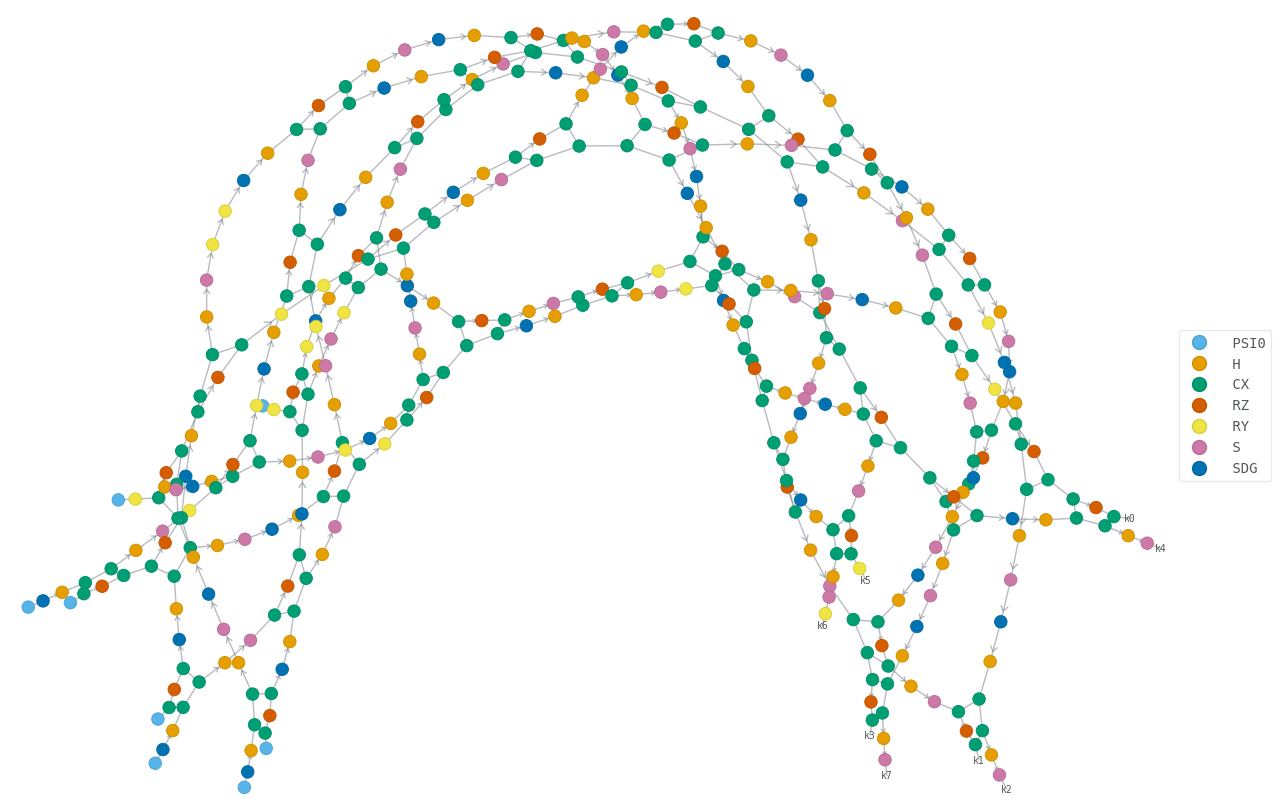

In [50]:
quimb_ansatz_N8g15.psi.draw(color=['PSI0', 'H', 'CX', 'RZ', 'RY', 'S', 'SDG'],figsize=(15,15))

In [81]:
(
    quimb_ansatz_N8g01.local_expectation(qu.pauli('X') & qu.pauli('X'), (4, 5)),
    quimb_ansatz_N8g07.local_expectation(qu.pauli('X') & qu.pauli('X'), (4, 5)),
    quimb_ansatz_N8g15.local_expectation(qu.pauli('X') & qu.pauli('X'), (4, 5))
)

((0.0012398008246550557+0j), (0.19210428979588767+0j), 0.8592054190512544)

In [110]:
reh01 = quimb_ansatz_N8g01.local_expectation_rehearse(qu.pauli('Z') & qu.pauli('Z'), (2, 6) )
reh01 = quimb_ansatz_N12g01.local_expectation_rehearse(qu.pauli('Z') & qu.pauli('Z'), (2, 6) )
reh07 = quimb_ansatz_N8g07.local_expectation_rehearse(qu.pauli('Z') & qu.pauli('Z'), (2, 6) )
reh15 = quimb_ansatz_N8g15.local_expectation_rehearse(qu.pauli('Z') & qu.pauli('Z'), (2, 6) )

In [111]:
(
    reh01['tree'].contraction_width(),
    reh07['tree'].contraction_width(),
    reh15['tree'].contraction_width()
)

(1, 4.0, 9.0)

In [112]:
(
    reh01['tree'].contraction_cost(),
    reh07['tree'].contraction_cost(),
    reh15['tree'].contraction_cost()
)

(0, 322, 23652)

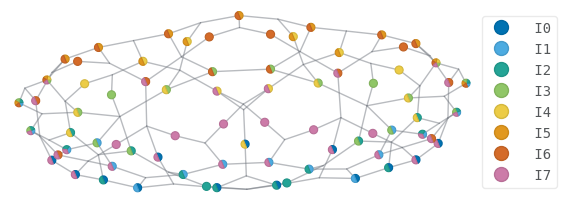

In [76]:
quimb_ansatz_N8g15.local_expectation_rehearse(qu.pauli('Z') & qu.pauli('Z'), (4, 5) )['tn'].draw(color=[f'I{q}' for q in range(8)])


In [32]:
(
    quimb_ansatz_N8g01
    # get the tensor network
    .local_expectation_rehearse(qu.pauli('Z') & qu.pauli('Z'), (4, 5) )['tn']
    # plot it with each qubit register highlighted
    .draw(color=[f'I{q}' for q in range(10)])
)

SyntaxError: positional argument follows keyword argument (2415149122.py, line 4)

In [27]:
quimb_ansatz

<Circuit(n=8, num_gates=73, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

In [ ]:
simplify_sequence='ADCRS', 